In [7]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

import seaborn as sns
import numpy as np

In [3]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU or MacOS with Metal support
if torch.cuda.is_available() or torch.backends.mps.is_available():
    start_run(config_file=Path("1_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)

2025-05-26 14:06:26,696: Logging to c:\Project Files\Alex\neuralhydrology\own\CMAL\runs\test_run_2605_140626\output.log initialized.
2025-05-26 14:06:26,699: ### Folder structure created at c:\Project Files\Alex\neuralhydrology\own\CMAL\runs\test_run_2605_140626
2025-05-26 14:06:26,700: ### Run configurations for test_run
2025-05-26 14:06:26,703: experiment_name: test_run
2025-05-26 14:06:26,705: train_basin_file: 1_basin.txt
2025-05-26 14:06:26,707: validation_basin_file: 1_basin.txt
2025-05-26 14:06:26,707: test_basin_file: 1_basin.txt
2025-05-26 14:06:26,707: train_start_date: 1999-10-01 00:00:00
2025-05-26 14:06:26,707: train_end_date: 2008-09-30 00:00:00
2025-05-26 14:06:26,707: validation_start_date: 1980-10-01 00:00:00
2025-05-26 14:06:26,719: validation_end_date: 1989-09-30 00:00:00
2025-05-26 14:06:26,723: test_start_date: 1989-10-01 00:00:00
2025-05-26 14:06:26,723: test_end_date: 1999-09-30 00:00:00
2025-05-26 14:06:26,727: device: cuda:0
2025-05-26 14:06:26,728: validate_ev

In [4]:
run_dir = Path("runs/test_run_2605_140626")
eval_run(run_dir=run_dir, period="test")

2025-05-26 14:38:50,372: Using the model weights from runs\test_run_2605_140626\model_epoch050.pt


c:\project files\alex\neuralhydrology\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(weight_fi

# Evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]
2025-05-26 14:38:53,418: Stored metrics at runs\test_run_2605_140626\test\model_epoch050\test_metrics.csv
2025-05-26 14:38:53,423: Stored results at runs\test_run_2605_140626\test\model_epoch050\test_results.p


In [5]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01022500'])

In [6]:
results['01022500']['1D']['xr']

<xarray.Dataset> Size: 2MB
Dimensions:         (date: 3652, time_step: 1, samples: 100)
Coordinates:
  * date            (date) datetime64[ns] 29kB 1989-10-01 ... 1999-09-30
  * time_step       (time_step) int64 8B 0
Dimensions without coordinates: samples
Data variables:
    QObs(mm/d)_obs  (date, time_step) float32 15kB 0.6203 0.5537 ... 0.9992
    QObs(mm/d)_sim  (date, time_step, samples) float32 1MB 0.5876 ... 1.431

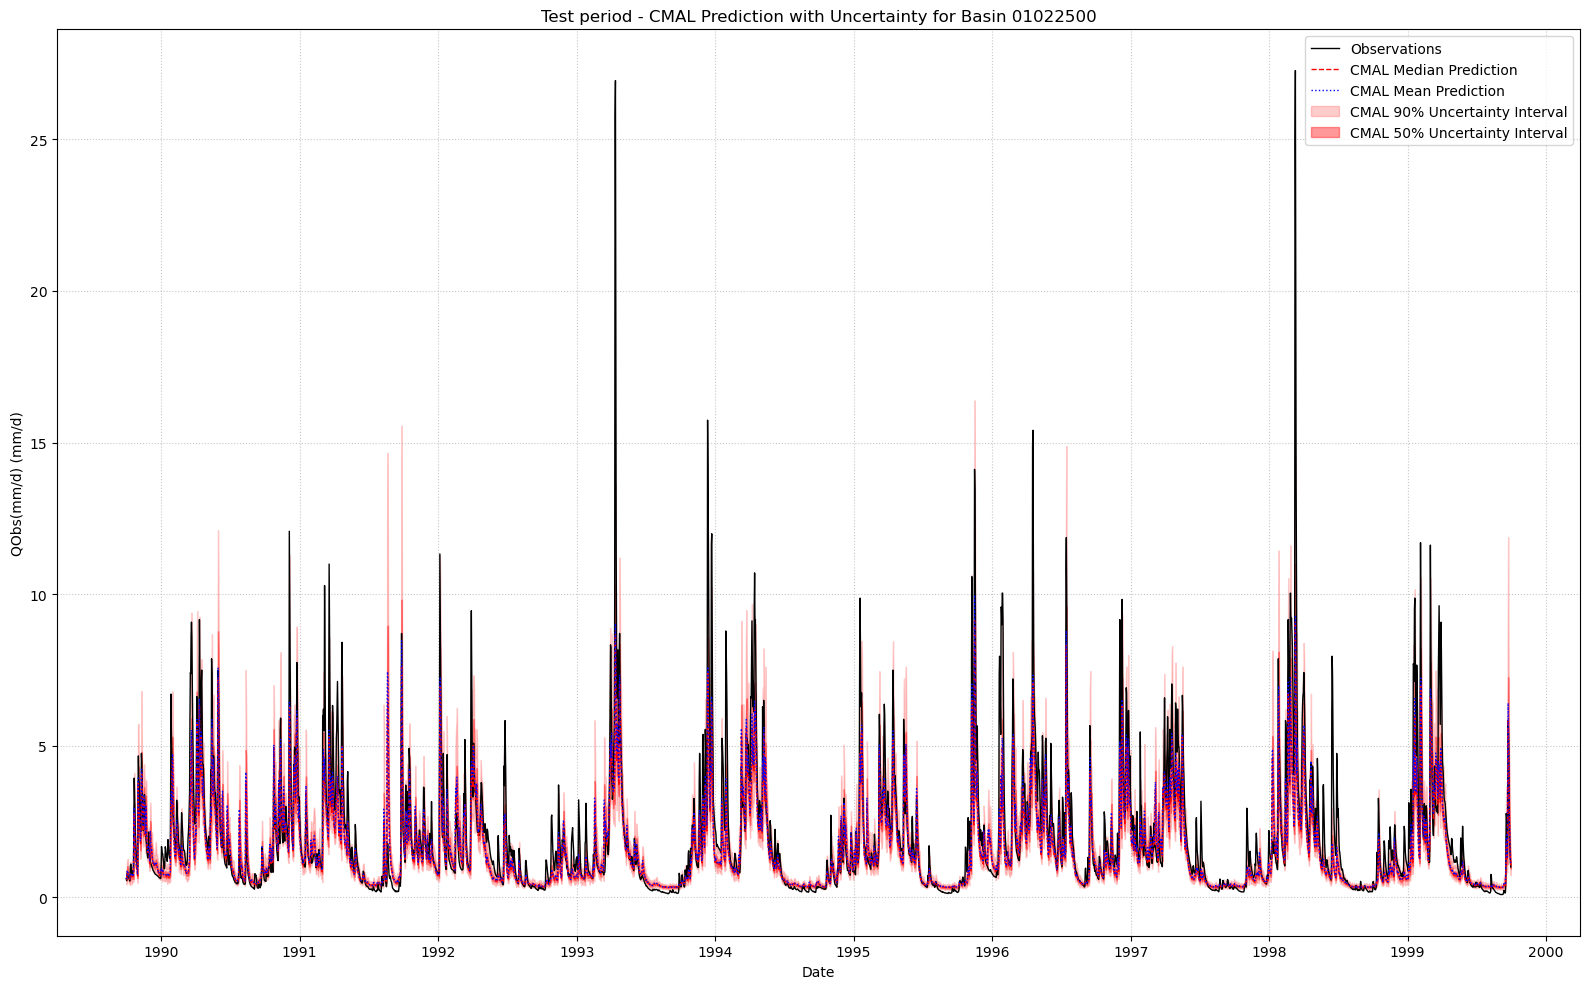

In [10]:
basin_id = '01022500' # Your basin ID
freq = '1D'           # Your frequency key
target_variable = 'QObs(mm/d)' # Your target variable name

# --- 1. Extract Observations ---
# Added .squeeze() here to make qobs a 1D array (removing the time_step dimension)
qobs = results[basin_id][freq]['xr'][f'{target_variable}_obs'].squeeze()

# --- 2. Extract Simulated Output with Samples ---
# This variable contains 100 samples for each time step
qsim_with_samples = results[basin_id][freq]['xr'][f'{target_variable}_sim']

# --- 3. Calculate Quantiles from Samples ---
# Convert the xarray DataArray to a NumPy array for easier percentile calculation.
# The 'samples' dimension is the last one in (date, time_step, samples).
qsim_data = qsim_with_samples.values

# Calculate percentiles across the 'samples' dimension (axis=-1)
# np.nanpercentile handles potential NaN values if present.
median_sim = np.nanpercentile(qsim_data, 50, axis=-1)  # 50th percentile (median)
q25 = np.nanpercentile(qsim_data, 25, axis=-1)         # 25th percentile
q75 = np.nanpercentile(qsim_data, 75, axis=-1)         # 75th percentile
lower_bound_90ci = np.nanpercentile(qsim_data, 5, axis=-1)   # 5th percentile (lower bound of 90% CI)
upper_bound_90ci = np.nanpercentile(qsim_data, 95, axis=-1) # 95th percentile (upper bound of 90% CI)
mean_sim = np.nanmean(qsim_data, axis=-1) # Use np.nanmean to handle NaNs

# Convert the percentile arrays back to xarray DataArray to retain 'date' coordinates
# Now, qobs.copy() will create a 1D xarray.DataArray, and median_sim.squeeze() is also 1D,
# so their shapes will match.
median_sim = qobs.copy(data=median_sim.squeeze())
q25 = qobs.copy(data=q25.squeeze())
q75 = qobs.copy(data=q75.squeeze())
lower_bound_90ci = qobs.copy(data=lower_bound_90ci.squeeze())
upper_bound_90ci = qobs.copy(data=upper_bound_90ci.squeeze())
mean_sim = qobs.copy(data=mean_sim.squeeze())

# --- 4. Plotting with Seaborn for Uncertainty ---
fig, ax = plt.subplots(figsize=(16, 10))

# Plot observations
ax.plot(qobs['date'], qobs.values, color='black', label='Observations', linewidth=1)

# Plot median prediction
ax.plot(median_sim['date'], median_sim.values, color='red', linestyle='--', label='CMAL Median Prediction', linewidth=1)
ax.plot(mean_sim['date'], mean_sim.values, color='blue', linestyle=':', label='CMAL Mean Prediction', linewidth=1)

# Plot uncertainty bands using fill_between
# 90% Confidence Interval (between 5th and 95th percentiles)
ax.fill_between(
    lower_bound_90ci['date'].values,
    lower_bound_90ci.values,
    upper_bound_90ci.values,
    color='red',
    alpha=0.2, # Lighter transparency for the wider band
    label='CMAL 90% Uncertainty Interval'
)

# 50% Confidence Interval (between 25th and 75th percentiles)
ax.fill_between(
    q25['date'].values,
    q25.values,
    q75.values,
    color='red',
    alpha=0.4, # Darker transparency for the narrower band
    label='CMAL 50% Uncertainty Interval'
)

ax.set_ylabel(f"{target_variable} (mm/d)")
ax.set_xlabel("Date")
ax.set_title(f"Test period - CMAL Prediction with Uncertainty for Basin {basin_id}")
ax.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# Calculate all metrics for the median prediction
values = metrics.calculate_all_metrics(qobs, mean_sim)

# Print the calculated metrics
print("\nMetrics for CMAL Median Prediction:")
for key, val in values.items():
    print(f"{key}: {val:.3f}")


Metrics for CMAL Median Prediction:
NSE: 0.698
MSE: 1.486
RMSE: 1.219
KGE: 0.582
Alpha-NSE: 0.640
Beta-KGE: 0.820
Beta-NSE: -0.163
Pearson-r: 0.886
FHV: -40.647
FMS: -2.538
FLV: 74.363
Peak-Timing: 0.217
Peak-MAPE: 40.860
